# Homework 4 Group 7

- First download the SVHN dataset from http://ufldl.stanford.edu/housenumbers/ and put it in a folder called SVHN on the same level as this notebook (or change the basepath under `data preparation and visualization` to the folder where you saved the dataset)

In [391]:
# Specify, if we are in training mode, the test mode will be automatically activated
training = True
test = False if training else True

## General setup

In [392]:
# Main imports
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [393]:
# General tensorflow settings
config = tf.ConfigProto()
# Use GPU in incremental mode (is ignored on CPU version)
config.gpu_options.allow_growth=True
# Add config=config in every tf.Session() -> tf.Session(config=config)

In [394]:
# Helper function to read the data
base_path = './SVHN'
import scipy.io

def load_svhn(path):
    
    matfile = scipy.io.loadmat(path)
    images = matfile['X']
    images = np.expand_dims(images,0)
    images = np.swapaxes(images, 0,4)
    images = np.squeeze(images)
    labels = matfile['y']
    labels = np.squeeze(labels)
    print(len(labels))
    
    validation_images = images[:10000,:,:,:]
    training_images = images[10000:,:,:,:]
    validation_labels = labels[:10000]
    training_labels = labels[10000:]
    
    return training_images, training_labels, validation_images, validation_labels


training_data, training_labels, validation_data, validation_labels = load_svhn('{}/train_32x32.mat'.format(base_path))

73257


## Data preparation and visualization

Training data shape: (63257, 32, 32, 3)
Training labels shape: (63257,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)


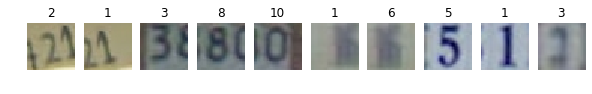

In [395]:
# Print some information about the data
print('Training data shape: {}'.format(training_data.shape))
print('Training labels shape: {}'.format(training_labels.shape))

print('Validation data shape: {}'.format(validation_data.shape))
print('Validation labels shape: {}'.format(validation_labels.shape))

# Visualize the first 10 images from the training data set

# Create a figure with 10 subplots
fig, ax = plt.subplots(1, 10, figsize=(10,10))

# Loop over the 10 subplots and print the corresponding image
for i in range(10):
    # Get the corresponing label and set it as the title of the plot
    ax[i].set_title(training_labels[i])
    # Show the image with grayscale colormap
    ax[i].imshow(training_data[i], cmap="gray")
    # Turn axis labeling off
    ax[i].axis("off")

In [396]:
# Create the dataset for tensorflow

# First we reset the graph
tf.reset_default_graph()

# Now we use the tf.data library to create a tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# Now we specifiy the respective batch sizes
training_batch_size = 64
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# Shuffle the training data in each epoch.
training_dataset = training_dataset.shuffle(buffer_size=len(training_data), reshuffle_each_iteration=True)

In [397]:
# Create the iterator 

# First we create the iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# We name the get_next method of the iterator to use it as a shortcut
next_batch = iterator.get_next()

# We prepare the initializer operations for both the training and the validation dataset
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

## Building the model

- information about layers, parameters etc here

In [398]:
# First we will format the data in the correct way

# We define our input data and the corresponding labels
input_data = next_batch[0]
# We have to cast the data to float32 (from uint8)
input_data = tf.cast(input_data, dtype=tf.float32)

# We transform our input to gray scale, to speed up training and the color should have no information in this dataset
standard_input =  tf.image.rgb_to_grayscale(input_data)
# We "normalize" our input
standard_input = tf.map_fn(lambda image: tf.image.per_image_standardization(image), standard_input)

# We have to cast our labels to int64
labels = tf.cast(next_batch[1], dtype=tf.int64)
# We transform our labels to one hot vectors
one_hot_labels = tf.one_hot(labels, 10)

In [399]:
# Apply the first convolution 
with tf.variable_scope("conv_layer1"):
    kernel_size = 5
    kernel_number = 32
    channels = 1
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh #tf.nn.leaky_relu
    #kernels = tf.Variable(tf.truncated_normal([kernel_size,
    #                                           kernel_size,
     #                                          channels,
      #                                         kernel_number],
       #                                       stddev=0.1))
    kernels = tf.get_variable(name="conv_layer1", shape=[kernel_size, kernel_size, channels, kernel_number],
                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(standard_input,
                              kernels,
                              strides=[1, stride, stride, 1],
                              padding=padding)
    feature_maps1 = activation_function(convolution + biases)   

In [400]:
# Apply the first pooling
with tf.variable_scope("pool_layer1"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling1 = tf.nn.max_pool(feature_maps1,
                              ksize=[1, kernel_size, kernel_size, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)

In [401]:
# Apply the second convolution
with tf.variable_scope("conv_layer2"):
    kernel_size = 3
    kernel_number = 64
    channels = 32
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh #tf.nn.leaky_relu
    #kernels = tf.Variable(tf.truncated_normal([kernel_size,
     #                                          kernel_size,
      #                                         channels,
       #                                        kernel_number],
        #                                      stddev=0.1)) 
    kernels = tf.get_variable(name="conv_layer1", shape=[kernel_size, kernel_size, channels, kernel_number],
                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(pooling1,
                              kernels,
                              strides=[1, stride, stride, 1],
                              padding=padding)
    feature_maps2 = activation_function(convolution + biases)

In [402]:
# Drop out!
# Define a placeholder to change probability between training
# and validation time.
keep_prob = tf.placeholder_with_default(1.0, shape=[])

In [403]:
# Apply the second pooling
with tf.variable_scope("pool_layer2"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling2 = tf.nn.max_pool(feature_maps2,
                              ksize=[1, kernel_size, kernel_size, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)
    # Apply droput after the second pooling
    dropout = tf.nn.dropout(pooling2, keep_prob)

In [404]:
# Apply the first fully connected layer
with tf.variable_scope("fully1"):
    new_shape = [-1, int(np.prod(dropout.shape[1:]))]
    flat_input = tf.reshape(dropout, shape=new_shape)
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 256
    activation_function = tf.tanh #tf.nn.leaky_relu
    
    weights_shape = [old_neuron_number, neuron_number]
    #xavier_val = np.sqrt(6.0/(np.sum(weights_shape)))
    #weights_init = tf.initializers.random_uniform(minval=-xavier_val, maxval=xavier_val)
    #weights = tf.get_variable("weights1", weights_shape, initializer=weights_init)
    weights = tf.get_variable("fully1", shape=weights_shape, initializer=tf.contrib.layers.xavier_initializer())
    
    # stddev = 1/np.sqrt(float(old_neuron_number))
    # rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    # weights = tf.Variable(rands, dtype=tf.float32)
    
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive 
    drive = flat_input @ weights + biases

    # And use the activation function
    output = activation_function(drive) 


In [405]:
# Apply the output layer
with tf.variable_scope("output"):
    flat_input = output
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 10
    activation_function = tf.nn.softmax
   
    weights_shape = [old_neuron_number, neuron_number]
    #xavier_val = np.sqrt(6.0/(np.sum(weights_shape)))
    #weights_init = tf.initializers.random_uniform(minval=-xavier_val, maxval=xavier_val)
    #weights = tf.get_variable("weights2", weights_shape, initializer=weights_init) 
    weights = tf.get_variable("output", shape=weights_shape, initializer=tf.contrib.layers.xavier_initializer())
    
    # stddev = 1/tf.sqrt(float(old_neuron_number))
    # rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    # weights = tf.Variable(rands, dtype=tf.float32)
    
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive (logits)
    logits = flat_input @ weights + biases

    # And use the softmax activation function
    prediction = activation_function(logits)
    prediction = tf.identity(prediction, name="prediction")

In [406]:
# Then we have to define our metrics

# Calculate the cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Define the accuracy
match_bools = tf.equal(labels, tf.argmax(prediction, axis=1))
accuracy = tf.reduce_mean(tf.cast(match_bools, dtype=tf.float32))

In [407]:
# We also have to define our optimizer
# Global step for decaying learning rate
global_step = tf.Variable(0)
# First we need to specify a learning rate 
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)
# Then we create an optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate)
# And tell the optimizer that it should minimize the loss
training_step = optimizer.minimize(loss, global_step=global_step)

In [408]:
# In the end we will specify some summaries, so that we can visualize our progress with tensorboard

# Specify the variables for the summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# Now we will merge our two summary scalars
merged_summaries = tf.summary.merge_all()

# We also have two specify two summary file writers 
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/')

In [409]:
# Only run this cell, if we are in training mode
if training:
    # Finally we can train our model
    import datetime
    timeNow = datetime.datetime.now()
    # First we specify the number of epochs
    epochs = 40

    # We create a saver to save the model and run predictions later on
    saver = tf.train.Saver()


    # We safely create our tensorflow session and pass our config parameters (for correct GPU usage, if GPU available)
    with tf.Session(config=config) as sess:

        # We initialize our variables
        sess.run(tf.global_variables_initializer())

        # We define a step counter (for the summaries)
        global_steps = 0

        # We will run our training as often as specified in epochs
        for ep in range(epochs):

            # Training Part
            # We have to load the training data into the iterator
            sess.run(training_init_op)

            # We have to loop over all our batches in every epoch
            while True:
                try:
                    # We train with one batch and read the summary and save it in the variable summary
                    _, summary = sess.run((training_step, merged_summaries), feed_dict={keep_prob:0.5})

                    # We write the summary to the disk at the specified location
                    train_writer.add_summary(summary, global_steps)

                    # We update our step counter
                    global_steps += 1

                # After we finished all batches, we catch the OutOfRangeError and break
                except tf.errors.OutOfRangeError:
                    break

            # Validation Part
            # We have to load the validation data into the iterator
            sess.run(validation_init_op)
            # We read out the summary  for the validation data (without training)
            summary, acc = sess.run((merged_summaries, accuracy))
            print('ep: {}, acc: {}'.format(ep, acc))

            # And we save the summary to the disk
            validation_writer.add_summary(summary, global_steps) 

        # Save the model at the end
        save_path = './checkpoints/model.ckpt'
        saver.save(sess, save_path, global_step=global_steps)
        print('saving checkpoint with acc.: {} at: {}'.format(acc, save_path))
    # Print the training time  
    print('needed {} seconds'.format(datetime.datetime.now()-timeNow))

ep: 0, acc: 0.7971000075340271
ep: 1, acc: 0.8238000273704529
ep: 2, acc: 0.8184000253677368
ep: 3, acc: 0.828000009059906
ep: 4, acc: 0.8155999779701233
ep: 5, acc: 0.8154000043869019
ep: 6, acc: 0.8281999826431274
ep: 7, acc: 0.8324000239372253
ep: 8, acc: 0.828000009059906
ep: 9, acc: 0.8256999850273132
ep: 10, acc: 0.8310999870300293
ep: 11, acc: 0.8378000259399414
ep: 12, acc: 0.8292999863624573
ep: 13, acc: 0.8399999737739563
ep: 14, acc: 0.8385000228881836
ep: 15, acc: 0.8385000228881836
ep: 16, acc: 0.8414999842643738
ep: 17, acc: 0.8388000130653381
ep: 18, acc: 0.8450000286102295
ep: 19, acc: 0.8414000272750854
ep: 20, acc: 0.8434000015258789
ep: 21, acc: 0.8450000286102295
ep: 22, acc: 0.8434000015258789
ep: 23, acc: 0.8406000137329102
ep: 24, acc: 0.8435999751091003
ep: 25, acc: 0.8402000069618225
ep: 26, acc: 0.8407999873161316
ep: 27, acc: 0.8374999761581421
ep: 28, acc: 0.8410999774932861
ep: 29, acc: 0.8424000144004822
ep: 30, acc: 0.8359000086784363
ep: 31, acc: 0.84009

In [410]:
# Only run this cell in test mode
if test:
    save_path = './checkpoints/model.ckpt-1240'
    with tf.Session(config=config) as sess:
        
        # Do not initialize variables by their initialization values!
        
        # Create a new Saver instance
        saver = tf.train.Saver()
        
        # Restore variable values by stored values
        saver.restore(sess, save_path)
        
        # Exchange this with test Part!
        # Validation Part
        # We have to load the validation data into the iterator
        sess.run(validation_init_op)
        # We read out the summary  for the validation data (without training)
        summary, acc = sess.run((merged_summaries, accuracy))
        print('Test acc: {}'.format(acc))

        # And we save the summary to the disk
        validation_writer.add_summary(summary, global_step)       